<a href="https://colab.research.google.com/github/oksami/cs6320project/blob/main/Integrated_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

import nltk

from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.corpus import stopwords

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer


# download nltk corpus (first time only)
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [3]:
# Load the dataset
path_news = '/content/drive/MyDrive/Data_NLP/ESG_daily_news.csv'
df = pd.read_csv(path_news, index_col=None)
#fill NaN with empty string
df = df.fillna('')

In [4]:
# Load the dataset
df = pd.read_csv(path_news, index_col=None)
#fill NaN with empty string
df = df.fillna('')
# create preprocess_text function
def preprocess_text(text):

    # Tokenize the text

    tokens = word_tokenize(text)




    # Remove stop words

    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]




    # Lemmatize the tokens

    lemmatizer = WordNetLemmatizer()

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]




    # Join the tokens back into a string

    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

# apply the function df

df['text'] = df['text'].apply(preprocess_text)
# initialize NLTK sentiment analyzer

analyzer = SentimentIntensityAnalyzer()


# create get_sentiment function

def get_sentiment(text):

    scores = analyzer.polarity_scores(text)

    sentiment = 1 if scores['pos'] > 0 else 0

    return sentiment




# apply get_sentiment function

df['sentiment'] = df['text'].apply(get_sentiment)
#negative sentiments are 0, positive are 1
#df.loc[df['sentiment']==0]

In [5]:
import spacy
nlp = spacy.load("en_core_web_sm")
docs = df['text'].apply(nlp)
ents = []
idx = 0
for doc in docs:
    for ent in doc.ents:
        ents.append([ent.text, ent.label_,idx])
    idx += 1
orgs = []
for a,b,c in ents:
    if b == 'ORG': orgs.append([a,df['sentiment'][c]])
orgs_df = pd.DataFrame(orgs, columns=["org","sentiment"])
orgs_df['sentiment'].value_counts(normalize=True) * 100
orgs_df.loc[orgs_df['sentiment']==0]

,org,sentiment
54,ESG,0
55,ESG,0
56,S & P 500Over,0
57,MorningstarThat,0
58,ESG,0
59,ESG,0
439,Westlands,0
440,Westlands,0
578,Stellantis,0
579,Fiats Peugeots,0


In [6]:
import numpy
import matplotlib.pyplot as plt
def visualizations(num):
    path_ratings = '/content/drive/MyDrive/Data_NLP/publiccompanyesgratings.csv'
    df2 = pd.read_csv(path_ratings)
    viz_df = df2.sample(num)
    group_by = viz_df.groupby("total_level").count().reset_index()
    sizes = group_by['ticker']
    labels = group_by['total_level']
    plt.pie(sizes, labels = labels,autopct='%1.1f%%')
    plt.show()
    x = viz_df["name"]
    y = viz_df["total_score"]
    #ax = df['ESG Risk Level'].value_counts().plot(kind='bar', figsize=(14,8))
    # setting the size of the figure
    fig = plt.figure(figsize=(10,10))
    #ax = df['Total ESG Risk score'].value_counts().plot(kind='bar', figsize=(14,8))
    plt.xticks(rotation=45,fontsize=5)
    plt.xlabel('Name', fontsize=5)
    plt.yticks(fontsize=5)
    plt.ylabel('Total ESG Score', fontsize=5)
    plt.bar(x, y)
    plt.show()

In [7]:
import re
import pandas as pd


# Define regex patterns for each intent and keyword extraction
intent_patterns = {
    "recommend": r"\b(recommend|show|suggest|list|give|find|top|best|fossil-free|gender equality|deforestation-free|gun-free|tobacco-free|prison-free|weapon-free)\b",
    "sentiment": r"\b(feel|sentiments?|feelings?|opinions?|positive(ly)?|negative(ly)?|news|thinks?|public|rated?|people)\b",
    "visualizing": r"\b(compare|visualize|show|top|display|view|contrast|analyze)\b"
}

# Function to extract intent based on regex matching
def extract_intent(query):
    query = query.lower()  # Convert to lowercase for case-insensitivity

    # Try matching each intent regex pattern to the query
    for intent, pattern in intent_patterns.items():
        if re.search(pattern, query):
            return intent

    return "unknown"  # Return "unknown" if no intent is matched


In [8]:
import spacy
# Define the sentiment_query function
def sentiment_query(query):
    """
    Processes the query to recognize intent and extract relevant entities (predicted_intent, company name, sentiment).

    Args:
        query (str): The user's input query.

    Returns:
        dict: A dictionary containing the predicted intent, fund type, and grades.
    """
    # Step 1: Intent Recognition using regex
    predicted_intent = "extract_intent(query)"  # Use the rule-based approach for intent recognition


    # Step 2: Entity Extraction (fund type and grades)
    # Define regex patterns for fund type and grades
    company = ""
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(query)
    for ent in doc.ents:
        if ent.label_ == 'ORG': company = ent.text
    # Combine results into a dictionary
    result = {
        "intent": predicted_intent,
        "company name": company
    }

    return result

In [9]:
import re

def visualization_query(query):
    """
    Extracts the first number from a given query.

    Args:
        query (str): The user query string.

    Returns:
        int: The first number found in the query, or None if no number is found.
    """
    # Regular expression to match integers, decimals, and negative numbers
    number_pattern = r"-?\b\d+\.?\d*\b"

    # Find the first number in the query
    match = re.search(number_pattern, query)

    # Return the number as a float, or None if no match is found
    return int(match.group()) if match else None



In [10]:
# Define the process_query function
def process_query_fund(query):
    """
    Processes the query to recognize intent and extract relevant entities (fund type, grades).

    Args:
        query (str): The user's input query.

    Returns:
        dict: A dictionary containing the predicted intent, fund type, and grades.
    """
    # Step 1: Intent Recognition using regex
    predicted_intent = extract_intent(query)  # Use the rule-based approach for intent recognition

    # Step 2: Entity Extraction (fund type and grades)
    # Define regex patterns for fund type and grades
    fund_type_pattern = r"(fossil-free|gender equality|deforestation-free|gun-free|tobacco-free|prison-free|weapon-free)"
    grade_pattern = r"\b[A-F]\b"  # Matches grades A to F

    # Extract fund type (fund-related categories)
    fund_type_match = re.search(fund_type_pattern, query)
    fund_type = fund_type_match.group(0) if fund_type_match else "Not specified"

    # Extract grades (A to F)
    grades = re.findall(grade_pattern, query)
    grade = ', '.join(grades) if grades else "Not specified"

    # Combine results into a dictionary
    result = {
        "intent": predicted_intent,
        "fund_type": fund_type,
        "grades": grade
    }

    return result


In [11]:
pip install owlready2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 57.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for owlready2: filename=owlready2-0.47-cp310-cp310-linux_x86_64.whl size=24075201 sha256=49128a2e23c4b29fa04e2ef6eed8652ee112a9842e1d59644e0a854760b5a166
  Stored in directory: /root/.cache/pip/wheels/27/3e/ba/4171c4b10bba9fe1774fbf8fcf794de889e636ce64ad83a533
Successfully built owlready2


In [12]:
def sentiment_results(company):
    check_company = (orgs_df['org'].eq(company)).any()
    if not check_company:
        return f"I'm sorry, I couldn't find any company matching {company}."
    response = f"The sentiment for {company} in the news is"
    senti = orgs_df.loc[orgs_df['org'] == company, 'sentiment'].iloc[0]
    if senti == 0: response += " negative."
    else: response += " positive."

    response += " Would you like more opinions on any other companies in the news?"
    return response

In [13]:
import torch
import re
import pandas as pd
from owlready2 import *

onto = get_ontology("/content/drive/MyDrive/Data_NLP/Protege_project.rdf").load()
# Map recognized fund types to ontology class names
fund_type_mapping = {
    "fossil-free": "FossilFreeFund",
    "deforestation-free": "DeforestationFreeFund",
    "gender equality": "GenderEqualityFund",
    "gun-free": "GunFreeFund",
    "prison-free": "PrisonFreeFund",
    "tobacco-free": "TobaccoFreeFund",
    "weapon-free": "WeaponFreeFund"
}

# Query ontology function (updated for multiple grades)
def query_ontology(onto, fund_types, grades):
    results = defaultdict(list)  # Group results by grade
    for fund_type in fund_types:
        fund_class = getattr(onto, fund_type_mapping[fund_type], None)
        if fund_class:
            for individual in fund_class.instances():
                if hasattr(individual, "Grade"):
                    # Check each grade in the query and group funds by grade
                    for grade in grades:
                        if grade in individual.Grade:
                            results[grade].append({
                                "name": individual.name,
                                "grade": grade,
                                "share_class": getattr(individual, "ShareClassType", "N/A"),
                                "category": getattr(individual, "CategoryGroup", "N/A"),
                                "weight": getattr(individual, "Weight", "N/A")
                            })

    return results

# Display results in a chatbot-friendly format (updated for multiple grades)
def display_detailed_results(funds_by_grade, grades, fund_types):
    if not funds_by_grade:
        return f"I'm sorry, I couldn't find any funds matching {(fund_types)} with grades: {(grades)}."

    response = f"Here are the top recommendations for {(fund_types)} funds with the requested grades:\n\n"

    for grade in grades:
        if grade in funds_by_grade:
            response += f"Grade: {grade}\n"
            for idx, fund in enumerate(funds_by_grade[grade][:5], 1):  # Limit to top 5 per grade
                response += (
                    f"{idx}. Fund: {fund['name']}\n"
                    f"   - Share Class: {fund['share_class']}\n"
                    f"   - Category: {fund['category']}\n"
                    f"   - Weight: {fund['weight']}\n"
                )
            response += "\n"

    response += "Would you like more funds under any other criteria?"
    return response


Welcome to the ESG Chatbot!

        I can assist you with the following:

        1. Recommend funds based on specific criteria:
           - Fossil-free funds
           - Deforestation-free funds
           - Prison-free funds
           - Gun-free funds
           - Weapon-free funds
           - Gender equality funds
           - Tobacco-free funds

           Please specify the GRADE level you'd like for these funds (A, B, C, D, E, F)

        2. Provide sentiment analysis about major world companies based on ESG-related news.

        3. Compare and visualize different companies based on their ESG ratings.

        How may I help you today?
        (Type 'exit' to quit the chatbot at any time.)
        
Enter your query: whats the weather today

I'm sorry, I couldn't understand your query. Please try again.

                Here's what I can assist you with:

                1. Recommend funds based on specific criteria:
                   - Fossil-free funds
                   

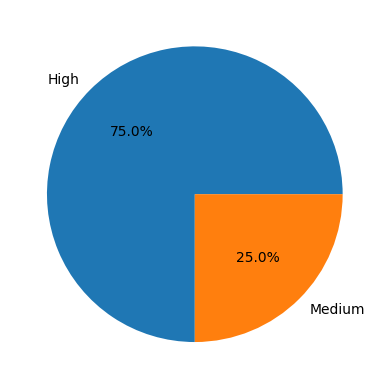

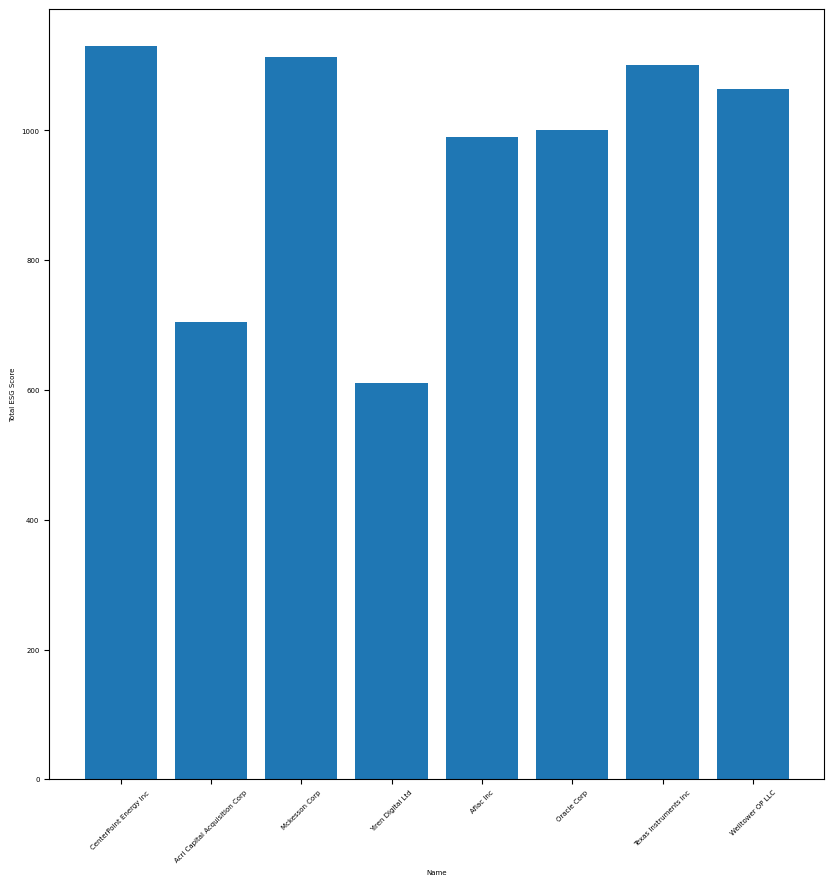


---
Enter your query: exit
Thank you for using the ESG Chatbot. Goodbye!


In [16]:
def chatbot():
    print("Welcome to the ESG Chatbot!")
    print(
        """
        I can assist you with the following:

        1. Recommend funds based on specific criteria:
           - Fossil-free funds
           - Deforestation-free funds
           - Prison-free funds
           - Gun-free funds
           - Weapon-free funds
           - Gender equality funds
           - Tobacco-free funds

           Please specify the GRADE level you'd like for these funds (A, B, C, D, E, F)

        2. Provide sentiment analysis about major world companies based on ESG-related news.

        3. Compare and visualize different companies based on their ESG ratings.

        How may I help you today?
        (Type 'exit' to quit the chatbot at any time.)
        """
    )

    while True:
        # Prompt the user for a query
        query = input("Enter your query: ").strip()

        # Check if the user wants to exit
        if query.lower() == "exit":
            print("Thank you for using the ESG Chatbot. Goodbye!")
            break

        # Extract the intent
        result = extract_intent(query)

        if result == "recommend":
            result_intent = process_query_fund(query)
            raw_results = query_ontology(onto, [result_intent["fund_type"]], result_intent["grades"])
            processed_results = display_detailed_results(raw_results, result_intent['grades'], result_intent['fund_type'])
            print("\nRecommended Funds:\n", processed_results)

        elif result == "sentiment":
            result_intent = sentiment_query(query)
            results = sentiment_results(result_intent["company name"])
            print("\nSentiment Analysis:\n", results)

        elif result == "visualizing":
            result_intent = visualization_query(query)
            print("\nVisualization Details:\n", result_intent)
            visualizations(result_intent)

        else:
            print("\nI'm sorry, I couldn't understand your query. Please try again.")
            print(
                """
                Here's what I can assist you with:

                1. Recommend funds based on specific criteria:
                   - Fossil-free funds
                   - Deforestation-free funds
                   - Prison-free funds
                   - Gun-free funds
                   - Weapon-free funds
                   - Gender equality funds
                   - Tobacco-free funds

                   Please specify the grade level you'd like for these funds (A, B, C, D, E, F)

                2. Provide sentiment analysis about major world companies based on ESG-related news.

                3. Compare and visualize different companies based on their ESG ratings.
                """
            )
        print("\n---")  # Separator for readability

# Run the chatbot
chatbot()
